In [2]:
import numpy as np
import torch 
import torchaudio
import lightning as pl
import pandas as pd
from matplotlib import pyplot as plt
import torchaudio.transforms as T
import librosa

In [3]:
time = 2
symbol_rate = 6
sample_rate = 480
carrying_freq = 12

In [4]:
def qpsk_modulation(time = time, symbol_rate=symbol_rate, sample_rate=sample_rate, carrying_freq=carrying_freq):
    num_symbols = int(time * symbol_rate)
    num_samples = int(time * sample_rate)
    samples_per_symbol = int(sample_rate/symbol_rate)

    bits = np.random.randint(0, 2, size=num_symbols * 2)

    symbols = bits.reshape(-1,2)

    phase_map = {
        (0,0): (1,1),
        (0,1): (-1,1),
        (1,1): (-1,-1),
        (1,0): (1,-1)
    }

    iq = np.array([phase_map[tuple(a)] for a in symbols])

    i_vals = iq[:, 0]
    q_vals = iq[:, 1]
    
    i_samples = np.repeat(i_vals, samples_per_symbol)
    q_samples = np.repeat(q_vals, samples_per_symbol)


    t = np.linspace(0,time, num_samples, endpoint=False)

    carrier_cos = np.cos(2 * np.pi * carrying_freq * t) * (np.sqrt(2)/2)
    carrier_sin = np.sin(2 * np.pi * carrying_freq * t) * (np.sqrt(2)/2)

    signal = i_samples * carrier_cos - q_samples * carrier_sin


    return t, signal, carrier_cos, carrier_sin

In [5]:
t, signal, _, _ = qpsk_modulation()

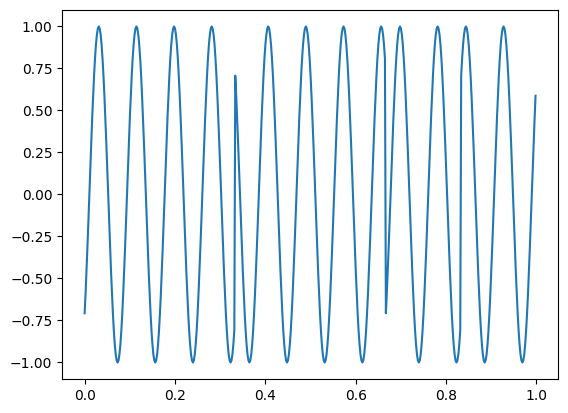

In [6]:
plt.plot(t[:480], signal[:480])

In [7]:
class QPSKAugmentations:
    def __init__(self, sample_rate = sample_rate, carrying_freq = carrying_freq):
        self.sample_rate = sample_rate
        self.carrying_freq = carrying_freq
        
        self.freq_mask = T.FrequencyMasking(freq_mask_param=5)
        self.time_mask = T.TimeMasking(time_mask_param=20)
        
    def add_gaussian_noise(self, signal: np.ndarray, snr_db: float = 20) -> np.ndarray:
        signal_power = np.mean(signal**2)
        noise_power = signal_power / (10 ** (snr_db / 10))
        noise = np.random.randn(len(signal)) * np.sqrt(noise_power)
        return signal + noise
    
    def add_multipath(self, signal: np.ndarray, 
                     max_delay: int = 20, 
                     max_attenuation: float = 0.7) -> np.ndarray:
        """Многолучевое распространение с случайными параметрами"""
        delay = np.random.randint(1, max_delay)
        attenuation = np.random.uniform(0.1, max_attenuation)
        delayed = np.roll(signal, delay) * attenuation
        return signal + delayed
    
    def add_doppler(self, signal: np.ndarray, 
                   max_shift: float = 2.0) -> np.ndarray:
        """Доплеровский сдвиг частоты"""
        t = np.arange(len(signal)) / self.sample_rate
        freq_shift = np.random.uniform(-max_shift, max_shift)
        return signal * np.cos(2 * np.pi * (self.carrying_freq + freq_shift) * t)
    
    def add_phase_jitter(self, signal: np.ndarray,
                        max_jitter: float = 0.2) -> np.ndarray:
        """Фазовая дрожь"""
        t = np.arange(len(signal)) / self.sample_rate
        jitter = max_jitter * np.random.randn(len(signal))
        return signal * np.cos(2 * np.pi * self.carrying_freq * t + jitter)
    
    def add_impulse_noise(self, signal: np.ndarray,
                         probability: float = 0.01,
                         max_amplitude: float = 5.0) -> np.ndarray:
        """Импульсные помехи"""
        noise = np.zeros_like(signal)
        impulses = np.random.rand(len(signal)) < probability
        noise[impulses] = max_amplitude * (2 * np.random.rand(np.sum(impulses)) - 1)
        return signal + noise
    
    def apply_torch_augmentations(self, signal: np.ndarray) -> np.ndarray:
        """Применение torchaudio аугментаций"""
        signal_tensor = torch.from_numpy(signal).float().unsqueeze(0)
        
        # Применяем аугментации с вероятностью 50%
        if np.random.rand() > 0.5:
            # Генерация шума
            noise = torch.randn_like(signal_tensor) * np.random.uniform(0.01, 0.1)
            signal_tensor = signal_tensor + noise
              
        if np.random.rand() > 0.5 and len(signal) > 20:
            signal_tensor = self.freq_mask(signal_tensor)
            signal_tensor = self.time_mask(signal_tensor)
            
        return signal_tensor.squeeze(0).numpy()
    
    def apply_all_augmentations(self, signal: np.ndarray,
                              apply_prob: float = 0.7) -> np.ndarray:
        """
        Применяет все аугментации последовательно
        с вероятностью apply_prob для каждой
        """
        augmented = signal.copy()
        
        if np.random.rand() < apply_prob:
            augmented = self.add_gaussian_noise(augmented, snr_db=np.random.uniform(10, 30))
            
        if np.random.rand() < apply_prob:
            augmented = self.add_multipath(augmented)
            
        if np.random.rand() < apply_prob:
            augmented = self.add_doppler(augmented)
            
        if np.random.rand() < apply_prob:
            augmented = self.add_phase_jitter(augmented)
            
        if np.random.rand() < apply_prob:
            augmented = self.add_impulse_noise(augmented)
            

            
        return augmented


In [8]:
def qpsk_dataset(num_samples, augmenter=None, augment_per_sample=3):
    """
    Генерирует набор данных с возможностью аугментации
    Args:
        num_samples: количество уникальных битовых последовательностей
        augmenter: объект аугментаций (None для чистых данных)
        augment_per_sample: сколько аугментированных версий создавать для каждого чистого сигнала
    """
    sample_len = int(time * sample_rate)
    
    if augmenter is None:
        # Только чистые сигналы
        dataset = np.empty((num_samples, sample_len))
        for i in range(num_samples):
            _, signal, _, _ = qpsk_modulation()
            dataset[i] = signal
        return dataset
    else:
        # Чистые сигналы + их аугментированные версии
        clean_signals = np.empty((num_samples, sample_len))
        augmented_signals = np.empty((num_samples * augment_per_sample, sample_len))
        
        for i in range(num_samples):
            # Генерация из одной битовой последовательности
            _, clean_signal, _, _ = qpsk_modulation()
            clean_signals[i] = clean_signal
            
            # Создаём несколько аугментированных версий
            for j in range(augment_per_sample):
                augmented_signals[i*augment_per_sample + j] = augmenter.apply_all_augmentations(clean_signal.copy())
                
        return clean_signals, augmented_signals

In [9]:
augmenter = QPSKAugmentations(sample_rate=sample_rate, carrying_freq=carrying_freq)

In [10]:
noised_data = qpsk_dataset(100, augmenter=augmenter)

In [11]:
noised_data[0].shape

(100, 960)

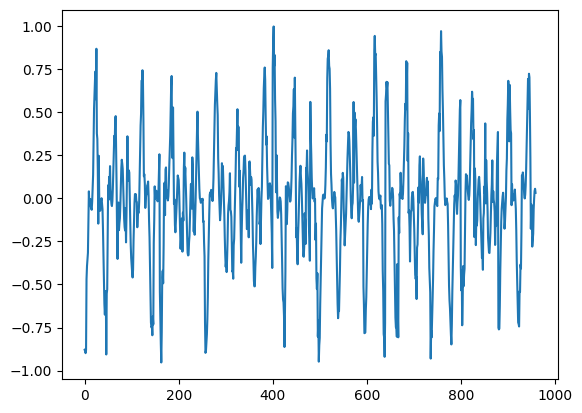

In [12]:
plt.plot(noised_data[1][7])

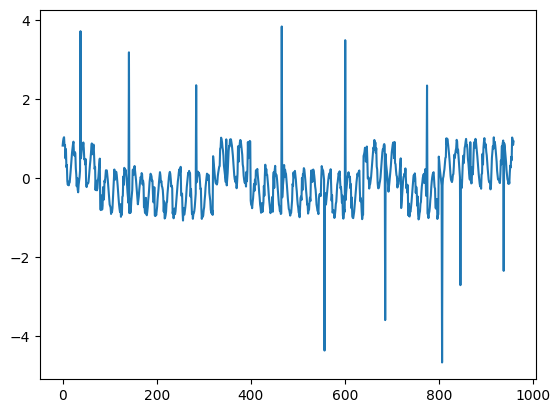

In [13]:
plt.plot(noised_data[1][25])

In [14]:
n_fft = 64  # Оптимальное значение для ваших параметров
win_length = n_fft  
hop_length = win_length // 4  # 25% перекрытие окон
power = None 

spectrogram_transform = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    power=power, 
)

In [15]:
signal = noised_data[0][0]

In [16]:
type(signal)

numpy.ndarray

In [17]:
signal_tensor = torch.FloatTensor(signal).unsqueeze(0)

In [18]:
stft = spectrogram_transform(signal_tensor)

In [19]:
# Получаем амплитуду и фазу
magnitude = torch.abs(stft).squeeze(0)  # Амплитудный спектр
phase = torch.angle(stft).squeeze(0)     # Фазовый спектр

# Переводим в numpy для визуализации
magnitude_np = magnitude.numpy()
phase_np = phase.numpy()

array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         4.2915344e-06,  4.5299530e-06,  4.5299530e-06],
       [-3.9433753e-06,  3.2842994e-01, -4.9229723e-01, ...,
        -2.6252728e+01, -2.6903294e+01, -2.8157589e+01],
       [ 3.1415925e+00,  3.1837852e+00,  2.6766376e+00, ...,
        -1.6801176e+01, -1.7529554e+01, -1.8749262e+01],
       ...,
       [-3.1415911e+00, -3.1502013e+00, -3.7042673e+00, ...,
        -1.0609204e+01, -9.6159344e+00, -9.6223917e+00],
       [-1.4329888e-07,  1.5646387e+00,  2.8233759e+00, ...,
         2.4242867e+01,  2.3470583e+01,  2.5034718e+01],
       [ 3.1415925e+00,  3.1415925e+00,  3.1415927e+00, ...,
         3.1415963e+00,  3.1415963e+00,  3.1415963e+00]], dtype=float32)

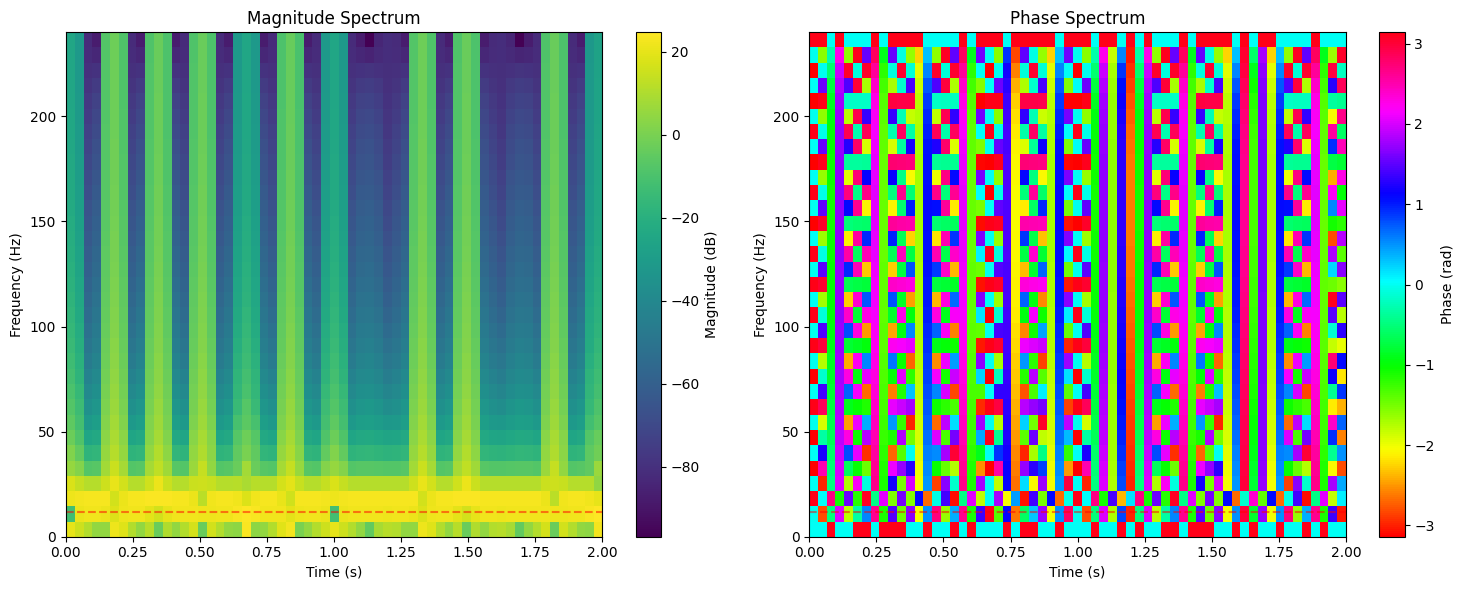

In [21]:
# Параметры осей
time_axis = np.arange(magnitude_np.shape[1]) * hop_length / sample_rate
freq_axis = np.arange(magnitude_np.shape[0]) * sample_rate / n_fft

# Создаем фигуру
plt.figure(figsize=(15, 6))

# Амплитудный спектр
plt.subplot(1, 2, 1)
plt.imshow(20 * np.log10(magnitude_np + 1e-12),
           extent=[time_axis.min(), time_axis.max(), freq_axis.min(), freq_axis.max()],
           aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Magnitude (dB)')
plt.title('Magnitude Spectrum')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.axhline(y=12, color='r', linestyle='--', alpha=0.5)

# Фазовый спектр
plt.subplot(1, 2, 2)
plt.imshow(phase_np,
           extent=[time_axis.min(), time_axis.max(), freq_axis.min(), freq_axis.max()],
           aspect='auto', origin='lower', cmap='hsv')
plt.colorbar(label='Phase (rad)')
plt.title('Phase Spectrum')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.axhline(y=12, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [22]:
noised_signal = noised_data[1][1]

In [23]:
noisignal_tensor = torch.FloatTensor(noised_signal).unsqueeze(0)

In [24]:
noised_stft = spectrogram_transform(noisignal_tensor)

In [25]:
# Получаем амплитуду и фазу
noise_magnitude = torch.abs(noised_stft).squeeze(0)  # Амплитудный спектр
noise_phase = torch.angle(noised_stft).squeeze(0)     # Фазовый спектр

# Переводим в numpy для визуализации
nmagnitude_np = noise_magnitude.numpy()
nphase_np = noise_phase.numpy()

In [42]:
np.unwrap(nphase_np).shape

(33, 61)

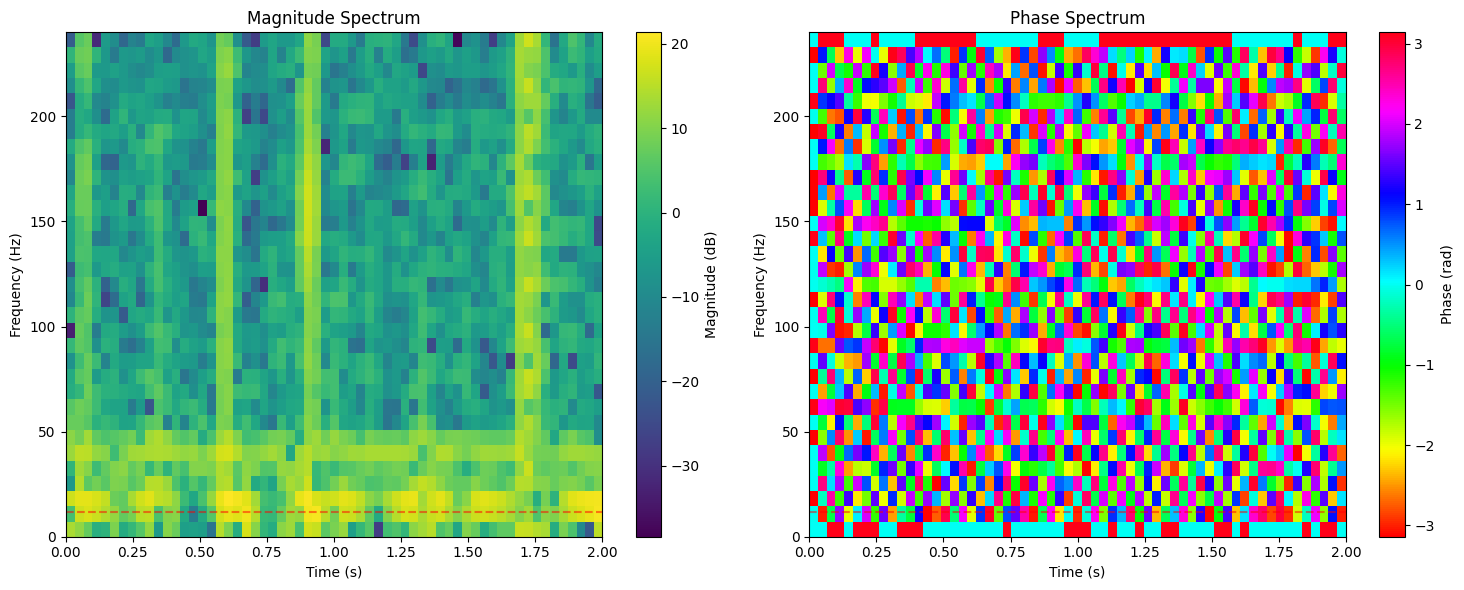

In [26]:
# Параметры осей
time_axis = np.arange(nmagnitude_np.shape[1]) * hop_length / sample_rate
freq_axis = np.arange(nmagnitude_np.shape[0]) * sample_rate / n_fft

# Создаем фигуру
plt.figure(figsize=(15, 6))

# Амплитудный спектр
plt.subplot(1, 2, 1)
plt.imshow(20 * np.log10(nmagnitude_np + 1e-12),
           extent=[time_axis.min(), time_axis.max(), freq_axis.min(), freq_axis.max()],
           aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Magnitude (dB)')
plt.title('Magnitude Spectrum')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.axhline(y=12, color='r', linestyle='--', alpha=0.5)

# Фазовый спектр
plt.subplot(1, 2, 2)
plt.imshow(nphase_np,
           extent=[time_axis.min(), time_axis.max(), freq_axis.min(), freq_axis.max()],
           aspect='auto', origin='lower', cmap='hsv')
plt.colorbar(label='Phase (rad)')
plt.title('Phase Spectrum')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.axhline(y=12, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

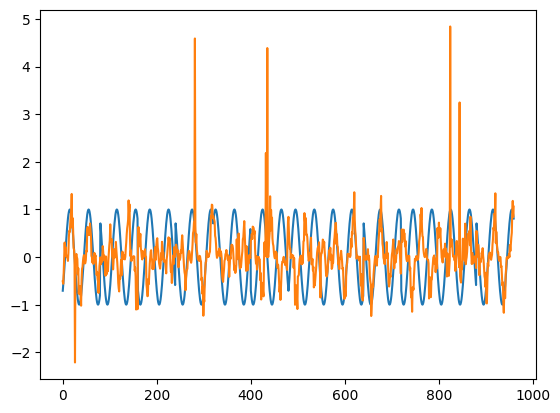

In [27]:
plt.plot(signal)
plt.plot(noised_signal)

In [28]:
"""
Наметки архитектуры
1. Генератор QPSK сигналов (Подтянуть теорию в вопросе модуляции)
1.1. Требуемые параметры - частота дискретизации, несущая частота, длительность сигнала (сек)
1.2. Гибкость в наложении шумов - имеет смысл сделать версию с простыми аугментациями, после уже пытаться генерировать что-то более неадекватное
2. Контрастивное обучение (вообще нужно, и если да, то на каком этапе?) (в первой статье: https://arxiv.org/abs/2304.03588 используется только на pre-train и fine-tuning, backbone по типу UNet)
2.1. Сама архитектура будет энкодер-декодер - не вижу смысл делать трансформер (поскольку сами последовательности короткие, а проблема затухающих градиентов вряд ли проявится, если использовать батчнорму и пр.)
2.2. Не трансформер = использовать только свертки, пулинги и проекции, без attention механизмов (возможно зря, нужны тесты)
2.3. Нужно прикинуть несколько возможных вариантов и переработать, дальше уже обдумывать датасет и пр.

Главный вопрос - как ставить задачу - если по первой статье, то будем кластеризовывать шумы (но только не претрейнинге, дальше тупо Unet) - это и есть SIMClr. Потенциально полезная история - кластеризовать различные виды шумов уже из более реальных семплов,
соответственно разметить данные по аугментациям, а дальше думать над основной архитектурой - при чём будет решаться задача классификации на предобработанных кластерах, есть вопросы по их количеству и тому, что будем называть разными кластерами, но думаю это само решиться если взять 
огромный датасет)

Вопрос в backbone

По-факту нужны в любом случае ground-truth, однако они могут быть получены с помощью SIMCLR (см. выше), то есть я смогу подавать различные виды шумов, там будет использоваться patch-wise contrasting learning (Sn - различные шумы, n - число кластеров) 
(есть проблема с ground truth чистыми данными, однако они как раз таки могут выявиться на этапе кластеризации или потенциально их можно сгенерировать синтетикой))

Для того, что бы организовать процесс NASS нужны именно ground truth шумов, а не чистых сигналов, а их то мы как раз найдем с помощью SIMCLR (см.Ниже)

Данные: 
Вижу два основных варианта - генерировать QPSK или LibriMix

Плюсы генерации руками - интерпретируемость, возсможность генерировать максимально приближенные к реальным данные (именно QPSK модулированные, а не какие то случайные гармоники)
Минусы - сложно будет сгенерировать шумы, приближенные к реальным

Почему то все очень любят рассматривать спектрограммы данных, а не сами сигналы
LibriMix - 
Плюс - Огромный датасет, с различными аугментациями (400 GB), выбор частоты дискретизации
Минус - все- таки это не QPSK сигнал, а речь, соответственно может быть не применимо в моей задаче.

Думаю для проверки корректности работы на простых шумах правильно будет использовать QPSK модуляцию

Backbone 

В [1] написано, что NASS метод применим к любой "separator or masking net"
Нужно понять, что за STFT-like representation (думаю это все заменяется эмбеддингами из SIMCLR)

Датасет: 

Очевидно, для предваррительной кластеризации ои обучения будут исползьвоаться два разных датасета 

Promising papers:
https://arxiv.org/html/2305.10761v3 [1]
https://arxiv.org/abs/2304.03588 [2]

""";